/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: covariance is not positive-semidefinite.


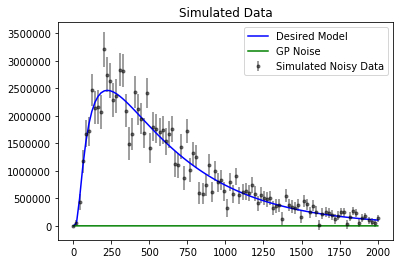

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import celerite as ce
from celerite.modeling import Model
import QPP_Funcs as QPP
from scipy.optimize import minimize, curve_fit

#setting our desired parameters that we want to "find"
paramstrue = [1e3, 1e-2, 3.2e+06, 1e+02, 5e+02]
log_paramstrue = np.log(paramstrue)

#defining a model class in celerite with our continuous model
class CTSModel_prior(Model):
    name="CTSModel_prior"
    parameter_names = ("log_A", "log_tau1", "log_tau2")
    
    def get_value(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        dA = (1./np.exp(self.log_A)) * self.get_value(t)
        dtau1 = ((1/(np.exp(self.log_tau2) * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(np.exp(self.log_tau2)**2)) - (np.exp(self.log_tau1)/((np.exp(self.log_tau2)**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
        
    #defining our somewhat naive prior, a simple tophat distribution for each parameter
    def log_prior(self):
        probA = 1.
        probtau1 = 1.
        probtau2 = 1.
        T=2000.
        if not (self.log_A>np.log(1e4) and self.log_A<np.log(3.5e7)):
            probA = 0.
        if not ((self.log_tau1>np.log(1) and self.log_tau1<np.log(T))):
            probtau1 = 0.
        if not ((self.log_tau2>np.log(1) and self.log_tau2<np.log(T))):
            probtau2 = 0.
        return np.log(probA * probtau1 * probtau2 * np.e)

truemodel = CTSModel_prior(log_A = log_paramstrue[2], log_tau1 = log_paramstrue[3], log_tau2 = log_paramstrue[4])    

#defining the kernel from the celerite RealTerm class so I can set my own prior
class RealTerm_Prior(ce.terms.RealTerm):
    name = "RealTerm_Prior"
    def log_prior(self):
        prob_a = 1.
        prob_c = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_a > -1e5) and (self.log_a < np.log(1e6))):
            prob_a = 0.
        if not (self.log_c > np.log(1./1000) and self.log_c < np.log(100)):
            prob_c = 0.
        return np.log(prob_a*prob_c * np.e)


#defining my simulation method using the kernel
def simulate(x, yerr, model, kernel):
    #generates a covariance matrix and then data using the multivariate normal distribution
    #could this be where the error is????
    K = kernel.get_value(x[:, None] - x[None, :])
    K[np.diag_indices(len(x))] += yerr**2
    y = np.random.multivariate_normal(model.get_value(x), K)
    return np.abs(y)

truekernel =  RealTerm_Prior(log_a = log_paramstrue[0], log_c = log_paramstrue[1])


#generating our simulated data
N = 100
x = np.linspace(1,2001,N)
ytrue = simulate(x, np.zeros(len(x)), truemodel, truekernel)
yerrscale = 2e2
yerr = np.sqrt(ytrue) * yerrscale
plt.figure()
plt.plot(x, ytrue, 'b-', label = "Desired Model")

ysim = simulate(x, yerr, truemodel, truekernel)

plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.plot(x, ytrue-truemodel.get_value(x), 'g-', label = "GP Noise")

plt.title("Simulated Data")
plt.legend()

plt.show()


In [2]:
#guessing initial model parameters
guess = np.array([np.log(2.5e6), np.log(50), np.log(100)])
model = CTSModel_prior(log_A = guess[0], log_tau1 = guess[1], log_tau2 = guess[2])

Initial log-likelihood: -2389.22185986
True log-likelihood: -1340.04980991
Final log-likelihood: -1412.24108698
Optimized log-parameters: [  6.21454208   2.30258509  14.73211515   4.86793613   6.44847127]
True log-parameters: [  6.90775528  -4.60517019  14.97866137   4.60517019   6.2146081 ]


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


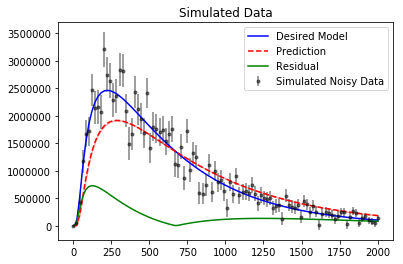

In [3]:
#initializing kernal and GP
kernel = RealTerm_Prior(log_a = np.log(500), log_c = np.log(10))

gp = ce.GP(kernel, mean = model, fit_mean = True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(ysim)))

#defining fitting functions for our GP
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

#setting initial terms and then optimizing
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

gp.set_parameter_vector(log_paramstrue)
print("True log-likelihood: {0}".format(gp.log_likelihood(ysim)))

gp.set_parameter_vector(initial_params)
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysim, gp))

gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))
print ("Optimized log-parameters: " + str(soln.x))
print ("True log-parameters: " + str(log_paramstrue))
ytest, yvar = gp.predict(ysim, x, return_var=True)
ystd = np.sqrt(yvar)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r--', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytrue-ytest), 'g-', label = "Residual")
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()


plt.show()


In [4]:
paramstart = soln.x
gp.set_parameter_vector(paramstart)
gp.compute(x, yerr)
#probability function for MCMC
def log_probability(params, y, gp):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    ll = gp.log_likelihood(y)
    result = ll + lp
    
    if not (np.isfinite(lp)):
        return -np.inf
    if np.isnan(ll)==True:
        return -np.inf
    return result


#sampling function for mcmc
def samplepdf(params):
    return np.random.normal(loc=params, scale = np.sqrt(np.abs(params)/7500.))



In [5]:
#initializing and running emcee sampler using same startpoint as MH-MCMC

import emcee
import corner

ndim = 5
nwalkers = 100
nsteps = 500
start = [samplepdf(paramstart) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysim, gp))
sampler.run_mcmc(start, nsteps)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/autograd/core.py:69: RuntimeWarning: overflow encountered in exp
  result_value = self.fun(*argvals, **kwargs)


(array([[ -4.31309469e+03,   1.69211096e-01,   1.49734861e+01,
           4.57562202e+00,   6.24389946e+00],
        [ -2.06852736e+04,  -2.21635164e+00,   1.50681226e+01,
           4.70790418e+00,   6.13291399e+00],
        [ -2.47836853e+04,  -2.33457059e+00,   1.49420782e+01,
           4.42151776e+00,   6.24710483e+00],
        [ -4.67988042e+03,  -5.75033772e+00,   1.50104875e+01,
           4.69089959e+00,   6.20485844e+00],
        [ -8.08709520e+04,  -1.86216166e-01,   1.49278983e+01,
           4.41071302e+00,   6.28895645e+00],
        [ -4.10994471e+02,  -6.13454580e+00,   1.50057920e+01,
           4.55412389e+00,   6.18626136e+00],
        [ -2.01876294e+04,   3.75989087e-01,   1.50030120e+01,
           4.65399815e+00,   6.18351511e+00],
        [ -9.54573472e+04,   2.93562072e+00,   1.49889632e+01,
           4.57344521e+00,   6.19673876e+00],
        [ -4.42648648e+03,   4.37996853e+00,   1.50155159e+01,
           4.79135753e+00,   6.17668200e+00],
        [ -1.361725

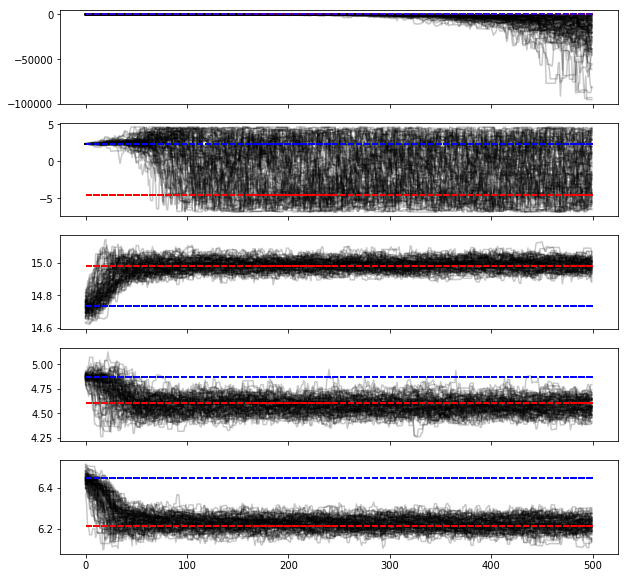

In [6]:
fig, axarr = plt.subplots(5, sharex=True, figsize = (10,10))
xline = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), sampler.chain[i,:,j], 'k-', alpha=1./np.log(nwalkers))
        trueval = log_paramstrue[j] * np.ones(len(xline))
        optval = soln.x[j] * np.ones(len(xline))
        axarr[j].plot(xline, trueval, 'r--')
        axarr[j].plot(xline, optval, 'b--')
plt.show()

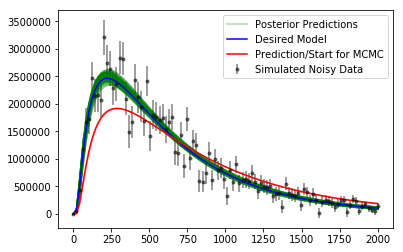

In [7]:
#plotting a sampling of results from emcee MCMC along with my previous work

labeled = False
for i in range(nsteps/10):
    params = sampler.chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gp.set_parameter_vector(params)
    
    ymc, ymcvar = gp.predict(ysim, x, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.3, label = "Posterior Predictions")
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')
            labeled = True
        else:  
            plt.plot(x, ymc, 'g-', alpha = 0.3)
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')

plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r-', label = "Prediction/Start for MCMC")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

            
plt.legend()    
plt.show()

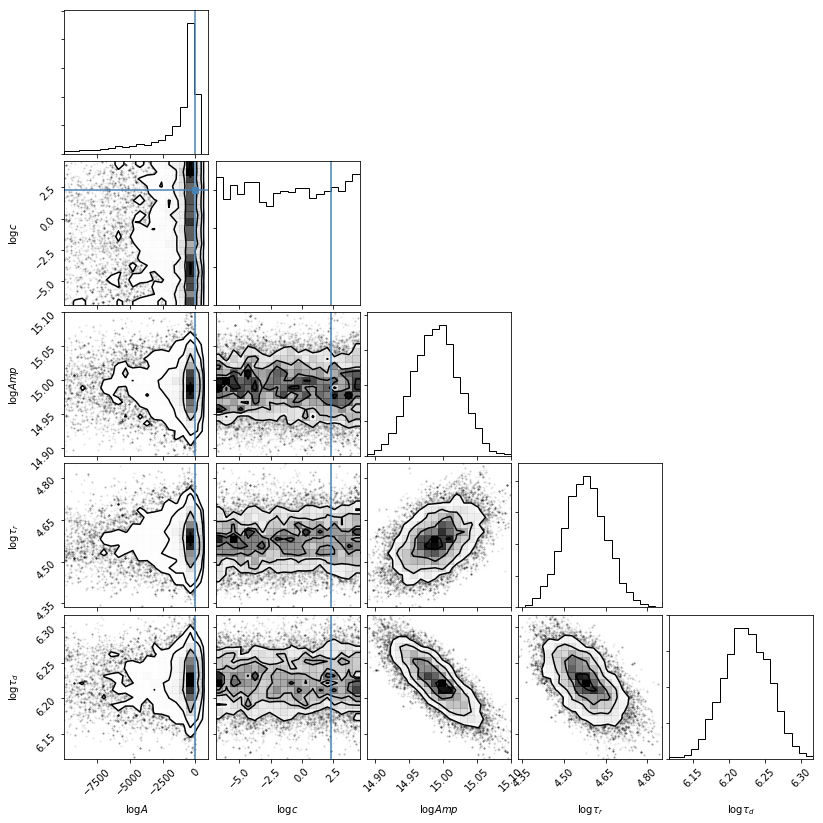

In [8]:
flat_samples = sampler.chain[:,200:, :].reshape((-1,ndim))
fig = corner.corner(flat_samples, labels = [r"$\log{A}$", r"$\log{c}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = soln.x, range=[(-1e4,1e3),.99999,.999,.999,.999])
plt.show()

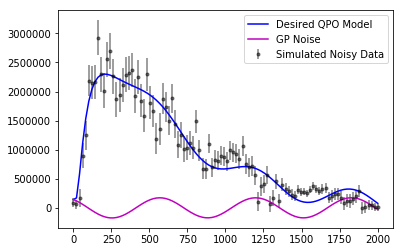

In [31]:
paramsq = [5e7, 1e4, 0.01, 3.2e+06, 1e+02, 5e+02]
log_paramsq = np.log(paramsq)

#defining a model class in celerite with our continuous model
class CTSModel_prior(Model):
    name="CTSModel_prior"
    parameter_names = ("log_A", "log_tau1", "log_tau2")
    
    def get_value(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        dA = (1./np.exp(self.log_A)) * self.get_value(t)
        dtau1 = ((1/(np.exp(self.log_tau2) * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(np.exp(self.log_tau2)**2)) - (np.exp(self.log_tau1)/((np.exp(self.log_tau2)**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
        
    #defining our somewhat naive prior, a simple tophat distribution for each parameter
    def log_prior(self):
        probA = 1.
        probtau1 = 1.
        probtau2 = 1.
        T=2000.
        if not (self.log_A>np.log(1e4) and self.log_A<np.log(3.5e7)):
            probA = 0.
        if not ((self.log_tau1>np.log(1) and self.log_tau1<np.log(T))):
            probtau1 = 0.
        if not ((self.log_tau2>np.log(1) and self.log_tau2<np.log(T))):
            probtau2 = 0.
        return np.log(probA * probtau1 * probtau2 * np.e)


class SHOTerm_Prior(ce.terms.SHOTerm):
    name = "SHOTerm_Prior"
    def log_prior(self):
        prob_S0 = 1.
        prob_Q = 1.
        prob_omega0 = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_S0 > -10) and (self.log_S0 < 20)):
            prob_S0 = 0.
        if not (self.log_Q > -10 and self.log_Q < 20):
            prob_Q = 0.
        if not (self.log_omega0 > -10 and self.log_omega0 < 20):
            prob_omega0 = 0.
        return np.log(prob_S0*prob_Q*prob_omega0 * np.e)
    
truemodelq = CTSModel_prior(log_A = log_paramsq[3], log_tau1 = log_paramsq[4], log_tau2 = log_paramsq[5])        
truekernelq = SHOTerm_Prior(log_S0 = log_paramsq[0], log_Q = log_paramsq[1], log_omega0 = log_paramsq[2])

plt.figure()
ytrueq = simulate(x, np.zeros(len(x)), truemodelq, truekernelq)
plt.plot(x, ytrueq, 'b-', label = "Desired QPO Model")
yerrscale = 2e2
yerr = np.sqrt(ytrueq) * yerrscale
ysimq = simulate(x, yerr, truemodelq, truekernelq)
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")
gpnoiseq = ytrueq-truemodelq.get_value(x)
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.legend()
plt.show()



Initial log-likelihood: -2359.37810562
True log-likelihood: -1341.91418013
Final log-likelihood: -1351.52084962
Optimized log-parameters: [  3.91238124   3.9125904    2.29791366  14.91418241   4.64560524
   6.26170128]
True log-parameters: [ 17.72753356   9.21034037  -4.60517019  14.97866137   4.60517019
   6.2146081 ]


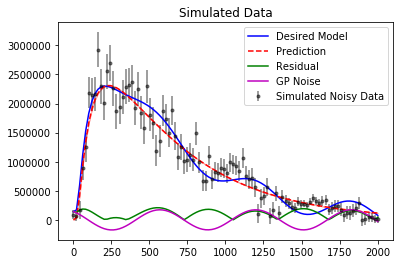

In [32]:
#initializing kernal and GP
kernelq = SHOTerm_Prior(log_S0 = np.log(50), log_Q = np.log(50), log_omega0 = np.log(10))
guess = np.array([np.log(3e6), np.log(10), np.log(300)])
modelq = CTSModel_prior(log_A = guess[0], log_tau1 = guess[1], log_tau2 = guess[2])


gpq = ce.GP(kernelq, mean = modelq, fit_mean = True)
gpq.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gpq.log_likelihood(ysimq)))


#setting initial terms and then optimizing
initial_params = gpq.get_parameter_vector()
bounds = gpq.get_parameter_bounds()

gpq.set_parameter_vector(log_paramsq)
print("True log-likelihood: {0}".format(gpq.log_likelihood(ysimq)))

gpq.set_parameter_vector(initial_params)
solnq = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysimq, gpq))

nit=0
while solnq.success==False:
    nit+=1
    print("Attempt "+str(nit)+"\tParams: " + str(soln.x))
    params = samplepdf(solnq.x)
    try:
        solnq = minimize(neg_log_like, params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysimq, gpq))
    except(RuntimeError):
        print "Whoops"

gpq.set_parameter_vector(solnq.x)
print("Final log-likelihood: {0}".format(-solnq.fun))
print ("Optimized log-parameters: " + str(solnq.x))
print ("True log-parameters: " + str(log_paramsq))
ytestq, yvarq = gpq.predict(ysimq, x, return_var=True)
ystdq = np.sqrt(yvarq)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrueq, 'b-', label = "Desired Model")
plt.plot(x, ytestq, 'r--', label = "Prediction")
plt.fill_between(x, ytestq+ystdq, ytestq-ystdq, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytrueq-ytestq), 'g-', label = "Residual")
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()


plt.show()


In [33]:
print solnq

      fun: 1351.5208496206549
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.34977215e-05,  -6.35244220e-05,  -9.64468483e-06,
        -1.55996043e-05,   4.90064831e-02,   2.48305887e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 71
      nit: 14
   status: 0
  success: True
        x: array([  3.91238124,   3.9125904 ,   2.29791366,  14.91418241,
         4.64560524,   6.26170128])


In [34]:
paramstartq = solnq.x
gpq.set_parameter_vector(paramstartq)
gpq.compute(x, yerr)
print gpq.log_prior()

def log_probability(params, y, gp):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    try:
        ll = gp.log_likelihood(y)
    except RuntimeError:
        ll = np.nan
    result = ll + lp
    
    if not (np.isfinite(lp)):
        return -np.inf
    if np.isnan(ll)==True:
        return -np.inf
    return result

def samplepdf(params, scale=1):
    return np.random.normal(loc=params, scale = np.sqrt(np.abs(params))*scale)

print log_probability(paramstartq,ysimq,gpq)

ndim = 6
nwalkers = 100
nsteps = 3000
start = [samplepdf(paramstartq,1e-10) for i in range(nwalkers)]
for i in range(nwalkers):
    attempt = 0
    while(log_probability(start[i], ysimq, gpq)==-np.inf):
        attempt += 1
        start[i] = samplepdf(paramstartq, 1e-10)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysimq, gpq))
sampler.run_mcmc(start, nsteps)


2.0
-1349.52084962
Walker 0 probability:-1349.52084964
Walker 1 probability:-1349.52084964
Walker 2 probability:-1349.52084963
Walker 3 probability:-1349.52084961
Walker 4 probability:-1349.52084964
Walker 5 probability:-1349.52084962
Walker 6 probability:-1349.52084959
Walker 7 probability:-1349.52084962
Walker 8 probability:-1349.52084963
Walker 9 probability:-1349.5208496
Walker 10 probability:-1349.52084963
Walker 11 probability:-1349.52084962
Walker 12 probability:-1349.52084961
Walker 13 probability:-1349.52084962
Walker 14 probability:-1349.52084963
Walker 15 probability:-1349.52084964
Walker 16 probability:-1349.52084964
Walker 17 probability:-1349.52084962
Walker 18 probability:-1349.5208496
Walker 19 probability:-1349.52084963
Walker 20 probability:-1349.52084961
Walker 21 probability:-1349.52084962
Walker 22 probability:-1349.52084961
Walker 23 probability:-1349.5208496
Walker 24 probability:-1349.52084964
Walker 25 probability:-1349.52084962
Walker 26 probability:-1349.5208

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


(array([[ -0.87409513,  -2.30613278,  -2.36066768,  14.96364028,
           4.78887861,   6.1586721 ],
        [  7.58137119,  10.07518004,   2.95975108,  15.01930264,
           4.73910288,   6.19579668],
        [ 16.84854926,  10.51060746,  -4.57108368,  14.95953984,
           4.67460795,   6.24166174],
        [ 13.35790038,  13.71079741,  -4.59143251,  14.96419561,
           4.56251597,   6.21615366],
        [ 11.34601339,  15.43338905,  -4.51512147,  15.00276391,
           4.74216542,   6.20782476],
        [  6.61719118,  17.35526153,  -0.45542888,  14.90588156,
           4.7609365 ,   6.22812596],
        [ 11.89064581,   2.83725491,  -6.16688782,  14.94754438,
           4.69658352,   6.26569279],
        [  8.82870413,  17.66493619,  -4.50049454,  14.9367075 ,
           4.47747996,   6.25539839],
        [ 12.43190049,  14.69865935,  -4.53750713,  14.93747733,
           4.68092039,   6.25332665],
        [  1.44341931,  13.30817393,   8.05890174,  14.9998407 ,
        

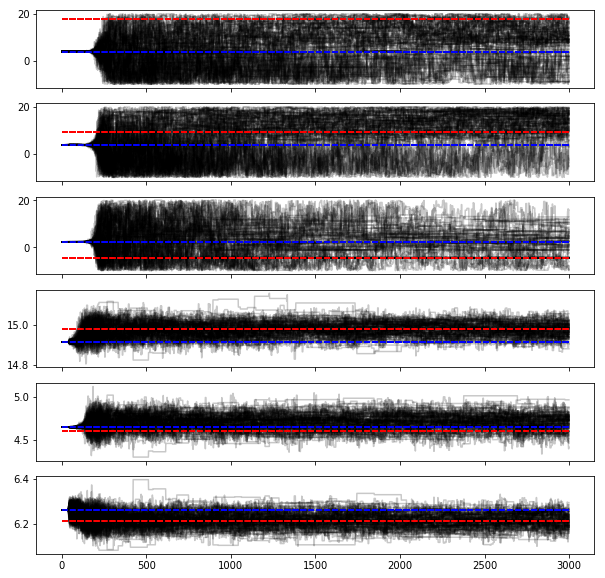

In [35]:
fig, axarr = plt.subplots(ndim, sharex=True, figsize = (10,10))
xline = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), sampler.chain[i,:,j], 'k-', alpha=1./np.log(nwalkers))
        trueval = log_paramsq[j] * np.ones(len(xline))
        optval = solnq.x[j] * np.ones(len(xline))
        axarr[j].plot(xline, trueval, 'r--')
        axarr[j].plot(xline, optval, 'b--')
plt.show()

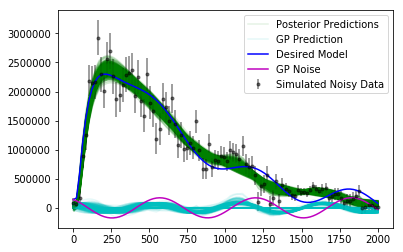

In [41]:
labeled = False
for i in range(nsteps/10):
    params = sampler.chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gpq.set_parameter_vector(params)
    modelq.set_parameter_vector(params[3:])
    ymc, ymcvar = gpq.predict(ysimq, x, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    gpnoisemc = ymc - modelq.get_value(x)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.1, label = "Posterior Predictions")
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.1, edgecolor='none')
            plt.plot(x, gpnoisemc, 'c-', label = "GP Prediction", alpha=0.1)
            labeled = True
        else: 
            plt.plot(x, ymc, 'g-', alpha = 0.1)
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.1, edgecolor='none')
            plt.plot(x, gpnoisemc, 'c-', alpha = 0.1)

plt.plot(x, ytrueq, 'b-', label = "Desired Model")
#plt.plot(x, ytestq, 'r-', label = "Prediction/Start for MCMC")
#plt.fill_between(x, ytestq+ystdq, ytestq-ystdq, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")


            
plt.legend()    
plt.show()

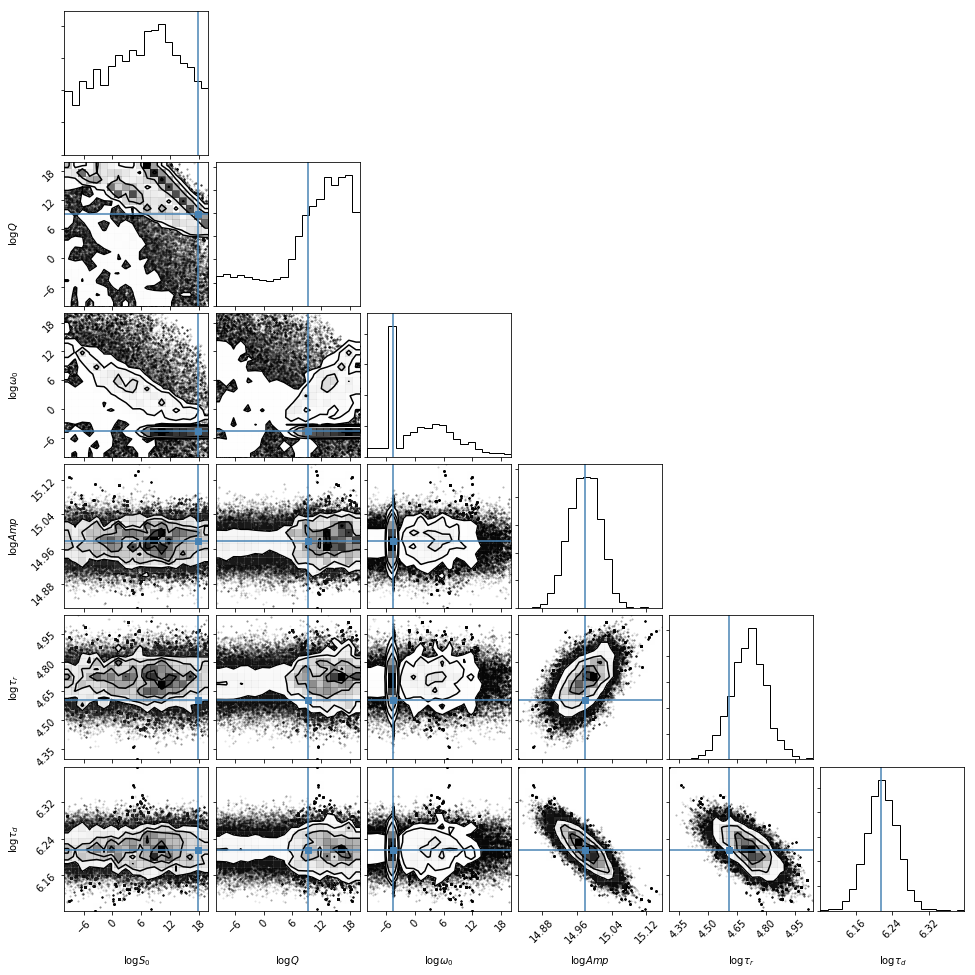

In [37]:
flat_samples = sampler.chain[:,200:, :].reshape((-1,ndim))
fig = corner.corner(flat_samples, bins= labels = [r"$\log{S_0}$", r"$\log{Q}$", r"$\log{\omega_0}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = log_paramsq, range = [1,1,1,1,1,1])
plt.show()

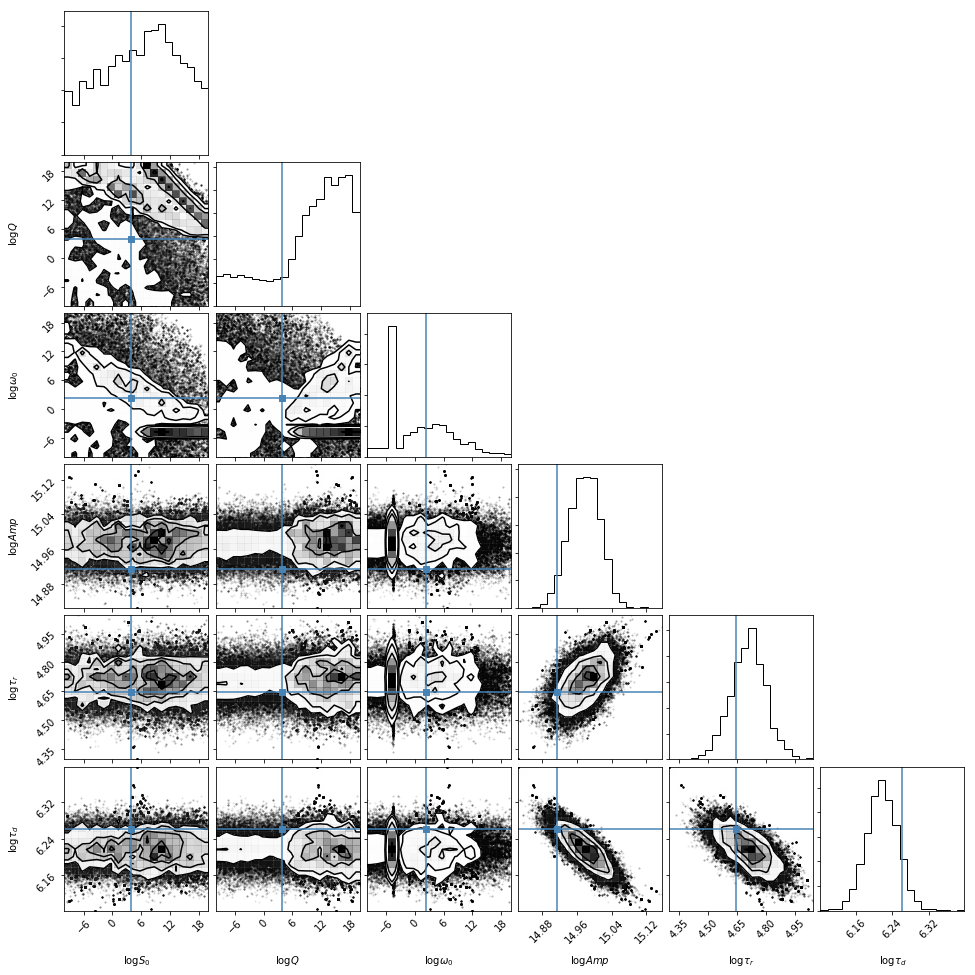

In [38]:
fig = corner.corner(flat_samples, labels = [r"$\log{S_0}$", r"$\log{Q}$", r"$\log{\omega_0}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = solnq.x, range = [1,1,1,1,1,1])
plt.show()

In [39]:
#writing things to file
import os
import pickle
fname = "Data/Test1"
write = True
simulated = True

try:
    if(os.path.exists(fname)==True):
        raise NameError('DirectoryExists')
    os.makedirs(fname)
except NameError:
    overwrite = raw_input("Error: Directory " + fname + " exists, overwrite?(y/n) ")
    if overwrite=='y':
        write=True
    else:
        write=False


def save_obj(obj, loc):
    with open(loc + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(loc):
    with open(loc + '.pkl', 'rb') as f:
        return pickle.load(f)

if(write==True):
    datafile = open(fname+"/lightcurve.txt", 'w+')
    for i in range(len(ysimq)):
        datafile.write(str(x[i])+'\t'+str(ysimq[i]) + '\t' + str(yerr[i])+'\n')
    datafile.close()
   

    infodict= {'params': paramsq, 'soln':solnq, 'chaindim':[nwalkers, nsteps, ndim]}
    if simulated==True:
        save_obj(truemodelq, fname+"/truemodel")
        save_obj(truekernelq, fname+"/truekernel")
    save_obj(modelq, fname+"/model")
    save_obj(kernelq, fname+"/kernel")
    save_obj(infodict, fname+"/info")
    save_obj(sampler.chain, fname+"/chain")

Error: Directory Data/Test1 exists, overwrite?(y/n) y


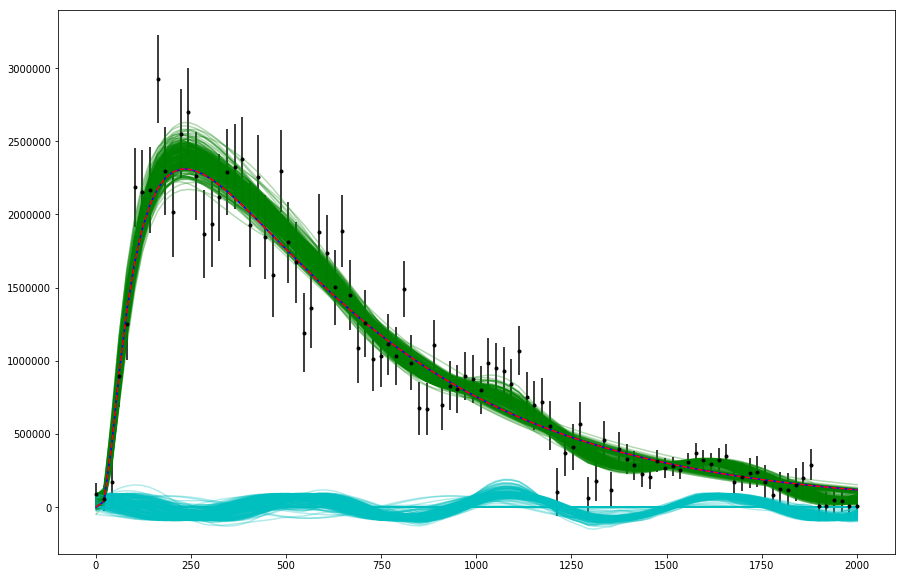

In [40]:
#reading things from file
plt.figure(figsize=(15,10))
xr,yr, yerrr = np.loadtxt(fname + '/lightcurve.txt',  unpack=True)
plt.errorbar(xr,yr, yerr=yerr, fmt='k.')


chain = load_obj(fname+'/chain')
modelload = load_obj(fname+'/model')
kernelload = load_obj(fname+'/kernel')
gpload = ce.GP(kernelload, mean = modelload, fit_mean = True)
gpload.compute(x, yerr)
labeled = False
for i in range(nsteps/10):
    params = chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gpload.set_parameter_vector(params)
    modelload.set_parameter_vector(params[3:])
    ymc, ymcvar = gpload.predict(yr, xr, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    gpnoisemc = ymc - modelload.get_value(xr)
    if not np.isnan(ymc).any():
            plt.plot(xr, ymc, 'g-', alpha = 0.3)
            plt.plot(xr, gpnoisemc, 'c-', alpha=0.3)
dictload = load_obj(fname+"/info")
modelload.set_parameter_vector(dictload['soln'].x[3:])
plt.plot(xr, modelload.get_value(xr), 'b-')

gpload.set_parameter_vector(dictload['soln'].x)
ypredict, yvar = gpload.predict(yr, xr, return_var=True)
ystd = np.sqrt(yvar)
plt.plot(xr, ypredict, 'r--')
plt.fill_between(x, ypredict+ystd, ypredict-ystd, color='r', alpha=0.3, edgecolor='none')
    
plt.show()